In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [29]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_component = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.286s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.029s


In [30]:
print(pca.explained_variance_ratio_)

[ 0.17834157  0.15017531  0.07357235  0.06102564  0.0537525   0.03035535
  0.02559071  0.02036333  0.02005557  0.01952437  0.01664161  0.01525641
  0.01258183  0.01113425  0.01080861  0.01038583  0.00960756  0.00902746
  0.00866254  0.00744635  0.00681805  0.00666364  0.00630892  0.00617944
  0.0057394   0.0054755   0.00528211  0.00474497  0.00456849  0.00437173
  0.00402137  0.00390814  0.00370735  0.00358782  0.00344199  0.00328456
  0.00309957  0.00307645  0.003064    0.0029731   0.00284413  0.00282791
  0.00265073  0.0025302   0.00246225  0.0023975   0.00235053  0.00228522
  0.00221261  0.00218376  0.00212495  0.00208904  0.00206946  0.00203342
  0.0019818   0.00193229  0.00184936  0.00179782  0.00177688  0.0017426
  0.00168688  0.00164726  0.0015918   0.00155868  0.0015499   0.00151557
  0.00147937  0.00146236  0.00144827  0.00142024  0.00136834  0.00135595
  0.00131085  0.00128703  0.001278    0.00126274  0.00122531  0.00120749
  0.00120321  0.00117436  0.00116534  0.00113357  0.

In [31]:
first_pc = pca.explained_variance_ratio_[0]
second_pc = pca.explained_variance_ratio_[1]

# print("first_pc = %1.8f, second_pc = %0.8f" % (first_pc, second_pc))
print('Variance explained by the first principal component:  {0}'.format(pca.explained_variance_ratio_[0]))
print('Variance explained by the second principal component: {0}'.format(pca.explained_variance_ratio_[1])) 

Variance explained by the first principal component:  0.17834157491483205
Variance explained by the second principal component: 0.1501753100433343


In [32]:
###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 17.272s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [33]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes))) 

Predicting the people names on the testing set
done in 0.104s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.80      0.82      0.81        60
  Donald Rumsfeld       0.79      0.85      0.82        27
    George W Bush       0.88      0.92      0.90       146
Gerhard Schroeder       0.90      0.72      0.80        25
      Hugo Chavez       1.00      0.73      0.85        15
       Tony Blair       0.84      0.72      0.78        36

      avg / total       0.85      0.84      0.84       322

[[  9   2   1   1   0   0   0]
 [  1  49   1   8   0   0   1]
 [  2   0  23   2   0   0   0]
 [  3   4   3 135   0   0   1]
 [  0   2   0   3  18   0   2]
 [  2   0   0   1   0  11   1]
 [  0   4   1   3   2   0  26]]


In [9]:
%matplotlib inline

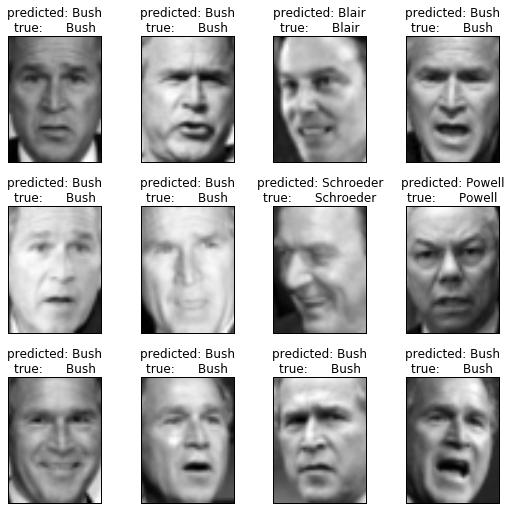

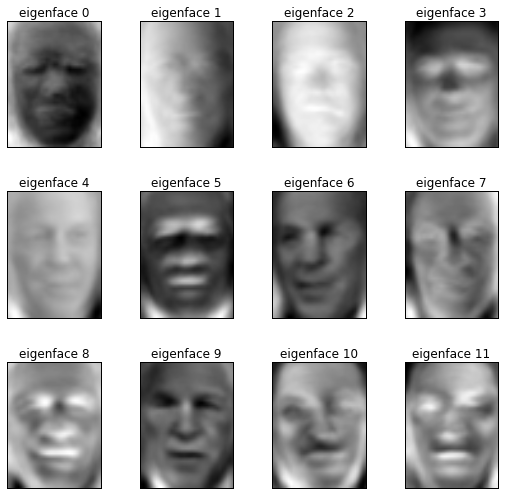

In [10]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

#pl.show()

### F1 Score vs. No. of PCs Used

In [34]:
for n_components in [10,15,25,50,100,250]:
    pca = RandomizedPCA(n_components=n_components,whiten=True).fit(X_train)
    
    eigenfaces = pca.components_.reshape((n_components,h,w))
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train a SVM classification model
    param_grid = {
           'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
            }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)


    # Quantitative evaluation of the model quality on the test set
    y_pred = clf.predict(X_test_pca)
    
    if n_components==10:
        print('n_components' + classification_report(y_test, y_pred, target_names=target_names).split('\n')[0])

    print('{0:12d}'.format(n_components) + classification_report(y_test, y_pred, target_names=target_names).split('\n')[2]) 

n_components                   precision    recall  f1-score   support
          10     Ariel Sharon       0.20      0.31      0.24        13
          15     Ariel Sharon       0.26      0.38      0.31        13
          25     Ariel Sharon       0.50      0.77      0.61        13
          50     Ariel Sharon       0.67      0.77      0.71        13
         100     Ariel Sharon       0.67      0.77      0.71        13
         250     Ariel Sharon       0.71      0.77      0.74        13
